## MTGNN with Linear Prediction and Reconstruction
The MTGNN model is used to project the input data into a feature space. <br />
From the output two linear convolution models are trained for <br />
prediction and reconstruction.

### MTGNN P+R

100%|██████████| 500/500 [29:23<00:00,  3.53s/it]


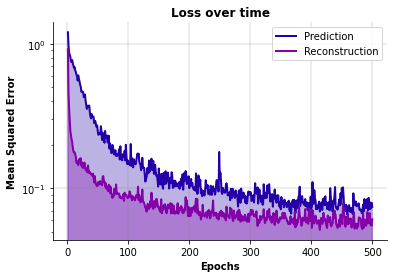

Train MSE: Prediction: 0.0744 - Reconstruction: 0.0612
Test MSE: Prediction: 0.0897 - Reconstruction: 0.0714


In [6]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch_geometric_temporal.nn.attention import MTGNN
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

from torch_geometric.data import DataLoader

loader = ChickenpoxDatasetLoader()

lags = 10
stride = 1
epochs = 500
batch_size = 32

dataset = loader.get_dataset(lags)

sample = next(iter(dataset))
num_nodes = sample.x.size(0)

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.4)

train_loader = DataLoader(list(train_dataset), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(test_dataset), batch_size=batch_size, shuffle=False)

### MODEL DEFINITION
class AttentionGCN(nn.Module):
    def __init__(self):
        super(AttentionGCN, self).__init__()

        residual_channels = 32
        skip_channels = 32
        end_channels = 32
        latent_dim = 32

        self.encoder = nn.Sequential(
            MTGNN(
                gcn_true=True,
                build_adj=True,
                gcn_depth=2,
                num_nodes=num_nodes,
                kernel_set=[5,5,5],
                kernel_size=5,
                dropout=0.2,
                subgraph_size=15,
                node_dim=64,
                dilation_exponential=3,
                conv_channels=9,
                residual_channels=residual_channels,
                skip_channels=skip_channels,
                end_channels=end_channels,
                seq_length=lags,
                in_dim=1,
                out_dim=latent_dim,
                layers=3,
                propalpha=0.4,
                tanhalpha=1,
                layer_norm_affline=True,
                xd=None
            ),
            nn.BatchNorm2d(latent_dim),
            nn.LeakyReLU()
        )

        self.prediction = nn.Sequential(
            nn.Conv2d(
                in_channels=latent_dim,
                out_channels=32,
                kernel_size=(1, 1),
                bias=True,
            ), 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=32,
                kernel_size=(1, 1),
                bias=True,
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=32,
                out_channels=1,
                kernel_size=(1, 1),
                bias=True,
            )
        )

        self.reconstruction = nn.Sequential(
            nn.Conv2d(
                in_channels=latent_dim,
                out_channels=64,
                kernel_size=(1, 1),
                bias=True,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=64,
                kernel_size=(1, 1),
                bias=True,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=64,
                out_channels=lags,
                kernel_size=(1, 1),
                bias=True,
            )
        )

    def forward(self, window):
        
        x = window.x.view(-1, 1, num_nodes, lags) # (batch, 1, lags, num_nodes)      
        h = self.encoder(x) # (batch, out_channels, num_nodes, 1)
        
        y_hat = self.prediction(h).squeeze(-1).permute(0,2,1).flatten()
        x_hat = self.reconstruction(h).squeeze(-1).permute(0,2,1).contiguous().view(-1, lags)
        
        return y_hat, x_hat

model = AttentionGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

### TRAIN
model.train()
nn.MSELoss
pred_loss_history = []
rec_loss_history = []
for _ in tqdm(range(epochs)):
    total_pred_loss = 0
    total_rec_loss = 0
    for i, window in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred, x_rec = model(window)

        assert y_pred.shape == window.y.shape
        assert x_rec.shape == window.x.shape 

        pred_loss = torch.mean((y_pred - window.y)**2)
        rec_loss = torch.mean((x_rec - window.x)**2)
        
        loss = pred_loss + rec_loss
        loss.backward()
        optimizer.step()

        total_rec_loss += rec_loss.item()
        total_pred_loss += pred_loss.item()

    total_rec_loss /= i+1
    total_pred_loss /= i+1

    pred_loss_history.append(total_pred_loss)
    rec_loss_history.append(total_rec_loss)

### TEST 
model.eval()
total_pred_loss = 0
total_rec_loss = 0
for i, window in enumerate(train_loader):
    optimizer.zero_grad()
    y_pred, x_rec = model(window)

    assert y_pred.shape == window.y.shape
    assert x_rec.shape == window.x.shape 

    pred_loss = torch.mean((y_pred - window.y)**2)
    rec_loss = torch.mean((x_rec - window.x)**2)
    
    loss = pred_loss + rec_loss
    loss.backward()
    optimizer.step()

    total_rec_loss += rec_loss.item()
    total_pred_loss += pred_loss.item()

total_rec_loss /= i+1
total_pred_loss /= i+1


### RESULTS PLOT
colors = ['#2300a8', '#8400a8'] # '#8400a8', '#00A658'
plot_dict = {'Prediction': (pred_loss_history, colors[0]), 'Reconstruction': (rec_loss_history, colors[1])}

n = len(pred_loss_history)

# plot train and val losses and fill area under the curve
fig, ax = plt.subplots()
x_axis = list(range(1, n+1))
for key, (data, color) in plot_dict.items():
    ax.plot(x_axis, data, 
                label=key, 
                linewidth=2, 
                linestyle='-', 
                alpha=1, 
                color=color)
    ax.fill_between(x_axis, data, 
                alpha=0.3, 
                color=color)

# figure labels
ax.set_title('Loss over time', fontweight='bold')
ax.set_xlabel('Epochs', fontweight='bold')
ax.set_ylabel('Mean Squared Error', fontweight='bold')
ax.legend(loc='upper right')

# remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# adds major gridlines
ax.grid(color='grey', linestyle='-', linewidth=0.35, alpha=0.8)

# y-axis in log scale (reconstruction loss tends to start high)
ax.set_yscale('log')
plt.show()

print("Train MSE: Prediction: {:.4f} - Reconstruction: {:.4f}".format(pred_loss_history[-1], rec_loss_history[-1]))
print("Test MSE: Prediction: {:.4f} - Reconstruction: {:.4f}".format(total_pred_loss, total_rec_loss))
